In [2]:
import pandas as pd
import typing
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import TimeSeriesSplit

In [3]:
df = pd.read_csv('data/load_data/Electricity_Profile.csv', sep=",", header=None)
df = df.rename(columns={0: 'load'})
df['time'] = df.index%2400
freq_minutes = 1
n_rows = len(df)
date_col = pd.date_range(start='2023-01-01', periods=n_rows, freq=f'{freq_minutes}min')
df['datetime'] = date_col
df.set_index('datetime', inplace=True)
df

,load,time
datetime,,
2023-01-01 00:00:00,200,0
2023-01-01 00:01:00,200,1
2023-01-01 00:02:00,200,2
2023-01-01 00:03:00,91,3
2023-01-01 00:04:00,91,4
...,...,...
2023-04-10 23:55:00,91,2395
2023-04-10 23:56:00,91,2396
2023-04-10 23:57:00,91,2397


In [4]:
df = df.iloc[::30]
df

,load,time
datetime,,
2023-01-01 00:00:00,200,0
2023-01-01 00:30:00,91,30
2023-01-01 01:00:00,200,60
2023-01-01 01:30:00,91,90
2023-01-01 02:00:00,200,120
...,...,...
2023-04-10 21:30:00,361,2250
2023-04-10 22:00:00,2361,2280
2023-04-10 22:30:00,91,2310


In [5]:
# split the data into inputs and targets
freq = 30          # 1 point every 30 min
step = int(60/freq)    # number of points in an hour
past = 6*24*step    # will be using last 6 days of data
future = 1*24*step  # to predict next 1 day


# I want to use a T-days window of input data for predicting target_class
# It means I need to prepend (T-1) last train records to the 1st test window
T = past  # my choice of the timesteps window
pred_T = future
def create_batches(train_data, val_data, T, pred_T, feature_name):
    train_features, train_labels  = train_data.drop(feature_name,axis=1), train_data[[feature_name]]
    test_features, test_labels = val_data.drop(feature_name,axis=1), val_data[[feature_name]]

    prepend_features = train_features.iloc[-(T-1):]
    test_features = pd.concat([prepend_features, test_features], axis=0)

    print(train_features.shape, train_labels.shape, test_features.shape, test_labels.shape)


    # Create sequences of T timesteps (=sliding window)
    # Normalize sequences X = X/X_0-1, where X_0 is 1st timestep in the window:
    X_train, y_train = [], []
    for i in range(train_labels.shape[0] - (T+pred_T-1)):
        X_train.append(train_features.iloc[i:i+T])
        y_train.append(train_labels.iloc[i + (T-1):i + (T-1)+pred_T])
    X_train, y_train = np.array(X_train), np.array(y_train)
    print(f'Train data dimensions: {X_train.shape}, {y_train.shape}')

    X_test, y_test = [], []
    for i in range(test_labels.shape[0]-pred_T):
        X_test.append(test_features.iloc[i:i+T])
        y_test.append(test_labels.iloc[i:i+pred_T])
    X_test, y_test = np.array(X_test), np.array(y_test)
    print(f'Test data dimensions: {X_test.shape}, {y_test.shape}')
    y_train = y_train.reshape(-1,future)
    y_test = y_test.reshape(-1,future)

    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    
    X_train = scaler_x.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    y_train = scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape).reshape(-1,future)

    X_test= scaler_x.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    y_test= scaler_y.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape).reshape(-1,future)

    print(f'(after normalisation)  TEST data dimensions: {X_test.shape}, {y_test.shape}')
    print(f'(after normalisation)  Train data dimensions: {X_train.shape}, {y_train.shape}')

    return X_train, y_train, X_test, y_test, test_labels, scaler_x, scaler_y



500 (4800, 2)


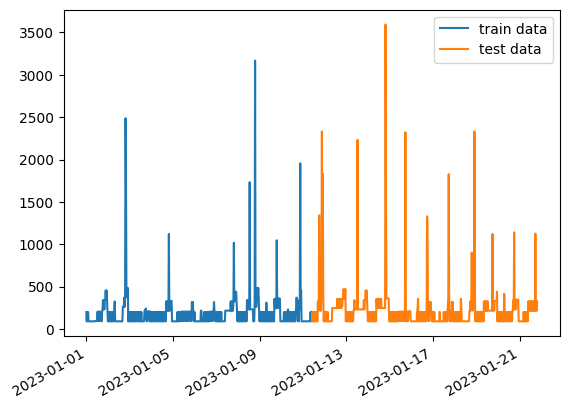

In [6]:
training_size = 500
print(training_size, df.shape)
train_data = df.iloc[:training_size]
val_data = df.iloc[training_size:training_size+training_size]
plt.plot(train_data.index, train_data[['load']], label = 'train data')
plt.plot(val_data.index, val_data[['load']], label='test data')
plt.legend()
plt.gcf().autofmt_xdate()

In [7]:
X_train, y_train, X_test, y_test, test_labels, scaler_x, scaler_y = create_batches(train_data, val_data, T, pred_T, 'load')
print(type(X_train), type(y_train))

(500, 1) (500, 1) (787, 1) (500, 1)
Train data dimensions: (165, 288, 1), (165, 48, 1)
Test data dimensions: (452, 288, 1), (452, 48, 1)
(after normalisation)  TEST data dimensions: (452, 288, 1), (452, 48)
(after normalisation)  Train data dimensions: (165, 288, 1), (165, 48)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [8]:
# Let's make a list of CONSTANTS for modelling:
LAYERS = [T, future*2, future*2, future]             # number of units in hidden and output layers
M_TRAIN = X_train.shape[0]           # number of training examples (2D)
M_TEST = X_test.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = 1                                # number of features
BATCH = 256                          # batch size
EPOCH = 120                         # number of epochs
LR = 1e-3                            # learning rate of the gradient descent
LAMBD = 5e-2                         # lambda in L2 regularizaion
DP = 0.00                            # dropout rate
RDP = 0.00                           # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')

# Build the Model
# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(T,N), units=LAYERS[0],
            activation='tanh', recurrent_activation='hard_sigmoid',
            kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            dropout=DP, recurrent_dropout=RDP,
            return_sequences=True, return_state=False,
            stateful=False, unroll=False))
model.add(LSTM(units=LAYERS[1],
            activation='tanh', recurrent_activation='hard_sigmoid',
            kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            dropout=DP, recurrent_dropout=RDP,
            return_sequences=True, return_state=False,
            stateful=False, unroll=False))
model.add(LSTM(units=LAYERS[2],
            activation='tanh', recurrent_activation='hard_sigmoid',
            kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            dropout=DP, recurrent_dropout=RDP,
            return_sequences=False, return_state=False,
            stateful=False, unroll=False))
model.add(Dense(units=LAYERS[3], activation='relu'))

# Compile the model with Adam optimizer
model.compile(loss='mae', metrics=['accuracy'],
            optimizer=Adam(learning_rate=LR))
print(model.summary())



# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', patience=1, verbose=0, 
                            factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                           patience=90, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=False)

History = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH,
                    validation_split=0.2, shuffle=True,verbose=0, callbacks=[lr_decay, early_stop])
# Evaluate the model:
train_acc = History.history['accuracy'][-1]    #model.evaluate(X_train, y_train, batch_size=M_TRAIN)
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=M_TEST)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 2)}%')
print(f'fixed model test score = {round(test_acc * 100, 2)}%')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
plt.show()


# Make predictions
predictions = model.predict(X_test)

plt.plot(val_data.index, predictions)
plt.plot(val_data.index, y_test)

layers=[288, 96, 96, 48], train_examples=165, test_examples=452
batch = 256, timesteps = 288, features = 1, epochs = 120
lr = 0.001, lambda = 0.05, dropout = 0.0, recurr_dropout = 0.0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 288, 288)          334080    
                                                                 
 lstm_1 (LSTM)               (None, 288, 96)           147840    
                                                                 
 lstm_2 (LSTM)               (None, 96)                74112     
                                                                 
 dense (Dense)               (None, 48)                4656      
                                                                 
Total params: 560,688
Trainable params: 560,688
Non-trainable params: 0
________________________________________________________________